In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Dropout, Flatten
import time
from keras.utils.vis_utils import plot_model

from keras.models import load_model
from numpy.random import randn
import pandas as pd



from IPython import display

### Loading Dataset
Dataset **Fashion MNIST** contains 60,000 examples for training and 10,000 examples for testing. 
The digits are size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255

In [2]:
(train_images, trainY), (testX, testY) = tf.keras.datasets.fashion_mnist.load_data()
print(train_images.shape)
print(train_images.min(), train_images.max())

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
0 255


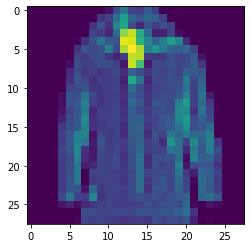

In [3]:
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
#normalizing values in [-1, 1]
train_images = (train_images - 127.5) / 127.5  
plt.imshow(train_images[19,:,:,0])

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


### The Generator


In [6]:
def make_generator_model():
    model = tf.keras.Sequential(name='generator')
    model.add(
        Dense(
            7*7*256,
            use_bias=False,
            input_shape=(100,)
        )
    )
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))

    model.add(
        Conv2DTranspose(
            filters=128, 
            kernel_size=(5, 5), 
            strides=(1, 1), 
            padding='same', 
            use_bias=False
        )
    )
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(
        Conv2DTranspose(
            filters=64, 
            kernel_size=(5, 5), 
            strides=(2, 2), 
            padding='same', 
            use_bias=False
        )
    )
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(
        Conv2DTranspose(
            filters=1, 
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='same',
            use_bias=False,
            activation='tanh'
        )
    )

    return model

In [7]:
generator = make_generator_model()
generator.build()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        51

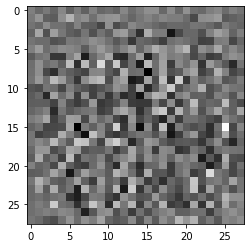

In [8]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
# plot_model(generator, show_shapes=True, show_layer_names=True)

### The Discriminator



In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential(name='discriminator')
    model.add(
        Conv2D(
            filters=64, 
            kernel_size=(5, 5), 
            strides=(2, 2), 
            padding='same',
            input_shape=[28, 28, 1]
        )
    )
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(
        Conv2D(
            filters=128, 
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='same'
        )
    )
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
    
    return model

In [10]:
dis = make_discriminator_model()
dis.build()
dis.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)            

In [11]:
discriminator = make_discriminator_model()
discriminator.build()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)            

In [15]:
decision = discriminator(generated_image, training=False)
print(decision)
# de = np.reshape (decision, (1,6272))
# print(de.shape)

tf.Tensor([[0.4994472]], shape=(1, 1), dtype=float32)


In [17]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

### Discriminator loss


$\frac{1}{m}\sum_{i=1}^{m}[\log D(\boldsymbol{x}^{(i)}) +\log(1-D(G(\boldsymbol{z}^{(i)})))]$


In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# print(real_loss = cross_entropy(tf.ones_like(real_output), real_output))

In [19]:
def generator_loss(fake_output):
    gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return gen_loss

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [22]:
EPOCHS = 101
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [23]:

@tf.function
def train_step(images, generator_optimizer, discriminator_optimizer, noise_dim):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [24]:
def train(dataset, epochs, generator_optimizer, discriminator_optimizer, noise_dim):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch, generator_optimizer, discriminator_optimizer, noise_dim)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [25]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      # plt.imsave('Single_image_at_epoch_{:04d}-{}.png'.format(epoch, i), predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()



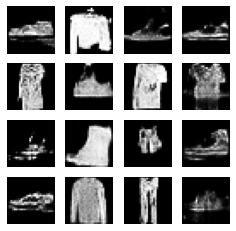

In [26]:
train(train_dataset, EPOCHS, generator_optimizer, discriminator_optimizer, noise_dim)


Restore the latest checkpoint.

In [27]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [28]:
generator.save('generator_model_fashionMNIST_100EPS.h5')

In [ ]:
# discriminator.save('discriminator_model_fashionMNIST_100EPS.h5')

1000
(1000, 28, 28, 1)
the shape of the z is  1000
(1000, 784)
(1000, 28, 28, 1)


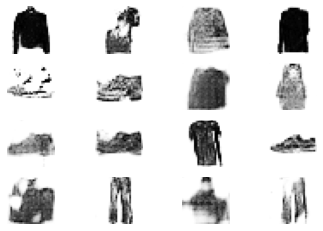

In [36]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()
# load model
model = load_model('generator_model_fashionMNIST_100EPS.h5')
# generate images
#Generate 16 images, each image provide a vector of size 100 as input
latent_points = generate_latent_points(100, 1000) 
print(len(latent_points))
# generate images
X = model.predict(latent_points)
# print(type(X))

x=X
z=x.shape
print(x.shape)
print("the shape of the z is ",z[0])
x=np.reshape(x, (x.shape[0], -1))


print(x.shape)

b= x

b= np.reshape(b, (-1,28,28,1))
print(b.shape)
import pandas as pd

mat_df = pd.DataFrame(x)
 
# exporting dataframe to CSV file.
mat_df.to_csv('GAN_images_10EPS.csv', header = None, index = None)

plt.imshow(b[3,:,:,0])

save_plot(X, 4)  


(1000, 784)
The new shape of file is :  (1000, 28, 28, 1)


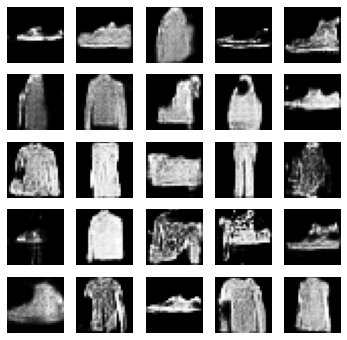

In [33]:
def load_fake_images():
  df = pd.read_csv('GAN_images_10EPS.csv', sep = ',', header = None)
  df= np.array(df)
  print(df.shape)
  fake_imgs =  np.reshape(df, (-1,28,28,1))
  # print(df.max(), df.min(), sep=' ')
  # plt.imshow(df[4,:,:,0])
  print("The new shape of file is : ", fake_imgs.shape)

  fig = plt.figure(figsize=(6, 6))
  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(fake_imgs[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  return df


imges= load_fake_images()

In [34]:
# def generating_img_csv(input_array):
#   total_img = input_array.shape
#   print("Shape of Input Array ", input_array.shape)
#   total_img= total_img[0]
#   input = np.reshape(input_array, (total_img,-1))
#   file = pd.DataFrame(input)
#   file.to_csv('auto_encoded_images.csv', sep = ',', header = None, index=False)



# def generating_latent_space(dim, samples):
#   # output= np.random.random(dim*samples)
#   output = randn(dim * samples)
#   output= output.reshape(samples, dim)
#   return output
# # generating_latent_space(100, 20).shape


# def save_plot(examples, n):
# 	# plot images
# 	for i in range(n * n):
# 		# define subplot
# 		plt.subplot(n, n, 1 + i)
# 		# turn off axis
# 		plt.axis('off')
# 		# plot raw pixel data
# 		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
# 	plt.show()
 


# model = load_model('autoencoder_denoised.h5')
# model.summary()
# # generate images
# # #Generate 10000 images, each image provide a vector of size 100 as input
# latent_points = generating_latent_space(100, 60000) 

# #Saving to CSV file for FID Implementation
# X = model.predict(latent_points)
# generating_img_csv(X)


# # plot the result
# # save_plot(X, 6)  #Plot 4x4 grid (Change to 5 if generating 25 images)

